
## Finding the model

This notebook uses a stored model if it exists. If you recently ran a training example that use the `%store%` magic, it will be restored in the next cell.

Otherwise, you can pass the URI to the model file (a .tar.gz file) in the `model_data` variable.

You can find your model files through the [SageMaker console](https://console.aws.amazon.com/sagemaker/home) by choosing **Training > Training jobs** in the left navigation pane. Find your recent training job, choose it, and then look for the `s3://` link in the **Output** pane. Uncomment the model_data line in the next cell that manually sets the model's URI.

In [1]:
model_data = 's3://sagemaker-us-west-2-522074741570/resnet-aoi-2021-03-11-01-22-46-702/output/model.tar.gz'

In [ ]:
# Retrieve a saved model from a previous notebook run's stored variable
%store -r model_data

# If no model was found, set it manually here.
# model_data = 's3://sagemaker-us-west-2-688520471316/pytorch-herring-mnist-2020-10-16-17-15-16-419/output/model.tar.gz'

print("Using this model: {}".format(model_data))

## Get Data 

You define the model object by using SageMaker SDK's `TensorFlowModel` and pass in the model from the `estimator` and the `entry_point`. The function loads the model and sets it to use a GPU, if available.

### Test the model

In [2]:
# Download the test set
import tensorflow as tf


import numpy as np
import random

DATA_GENERATOR_KWARGS = {"rescale": 1.0 / 255, "validation_split": 0.20}
IMAGE_SIZE = (224, 224)
batch_size = 32
INTERPOLATION = "bilinear"
dataflow_kwargs = dict(
    target_size=IMAGE_SIZE, batch_size=batch_size, interpolation=INTERPOLATION, 
)
data_dir = '/home/ec2-user/SageMaker/resnet-jumpstart/resnet-aoi-2/'
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**DATA_GENERATOR_KWARGS)
# valid_generator = valid_datagen.flow_from_directory(data_dir, subset="validation", shuffle=False, **dataflow_kwargs)
valid_generator = valid_datagen.flow_from_directory(data_dir, subset="validation", shuffle=False, **dataflow_kwargs)


(test_images, test_labels) = valid_generator.next()
test_images.shape

Found 1143 images belonging to 2 classes.
Found 1143 images belonging to 2 classes.


(32, 224, 224, 3)

(32, 224, 224, 3)

(4, 224, 224, 3)
(4, 224, 224, 3)


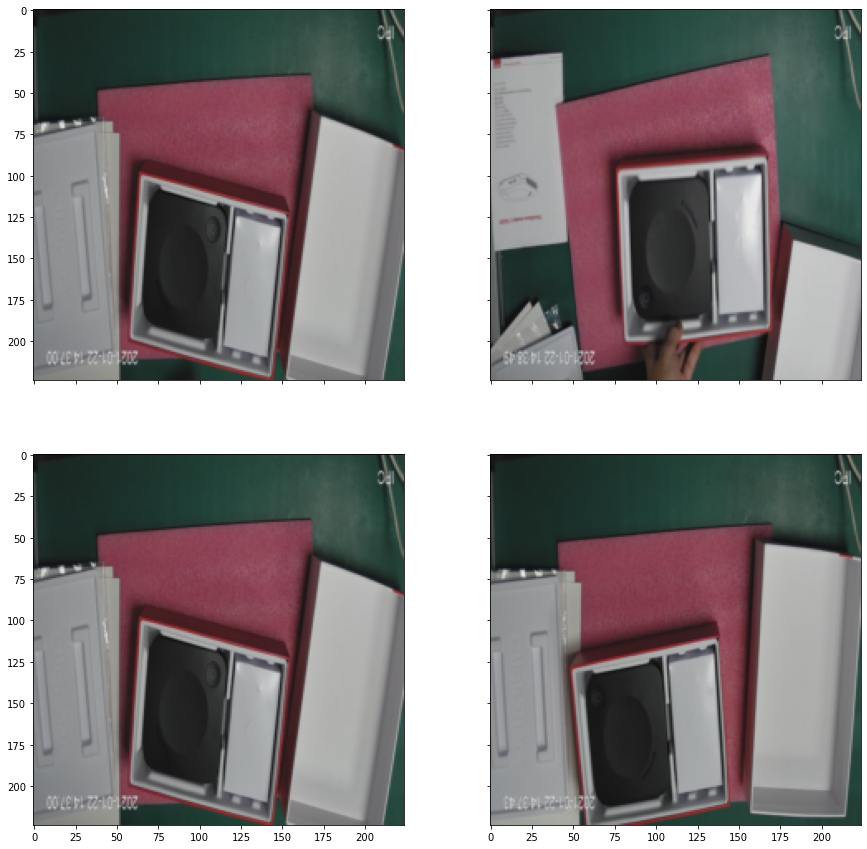

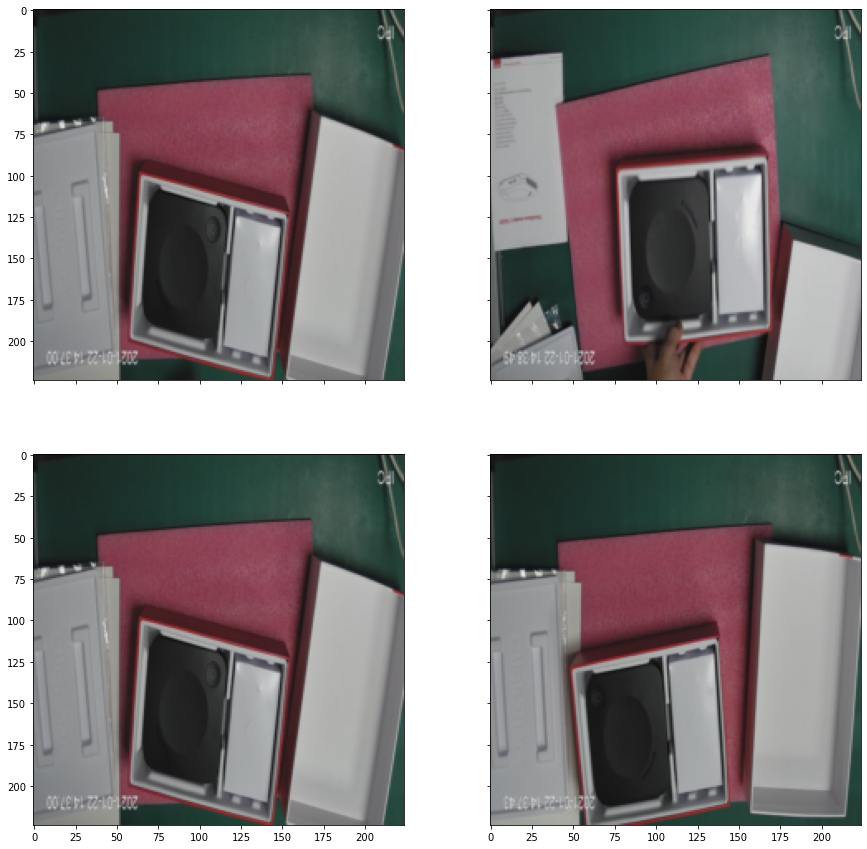

In [3]:


mask = random.sample(range(0, len(test_images)), 4)
mask = np.array(mask, dtype=np.int8)
samples = test_images[mask]
sample_labels = test_labels[mask]
print(samples.shape)
# Inspect sample images
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(15,15))
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.imshow(samples[2*i+j].reshape(224, 224,3))

In [4]:
model_data 

's3://sagemaker-us-west-2-522074741570/resnet-aoi-2021-03-11-01-22-46-702/output/model.tar.gz'

's3://sagemaker-us-west-2-522074741570/resnet-aoi-2021-03-11-01-22-46-702/output/model.tar.gz'

In [5]:
%%bash -s "$model_data" 
rm -rf s3_model 
mkdir s3_model
cd s3_model 
aws s3 cp $1 . 
tar -xf model.tar.gz 
ls ./1/

download: s3://sagemaker-us-west-2-522074741570/resnet-aoi-2021-03-11-01-22-46-702/output/model.tar.gz to ./model.tar.gz
assets
saved_model.pb
variables


download: s3://sagemaker-us-west-2-522074741570/resnet-aoi-2021-03-11-01-22-46-702/output/model.tar.gz to ./model.tar.gz
assets
saved_model.pb
variables


In [6]:
import keras
import tensorflow as tf 


export_dir = './s3_model/1/'

model = tf.saved_model.load(export_dir)



Using TensorFlow backend.
Using TensorFlow backend.


In [7]:
# answers 
print("ground truth:", np.argmax(sample_labels, axis=1))
# predictions 
print("prediction:", np.argmax(model((samples)), axis=1)) 


ground truth: [0 0 0 0]
ground truth: [0 0 0 0]
prediction: [0 0 0 0]
prediction: [0 0 0 0]


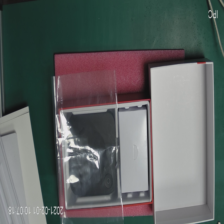

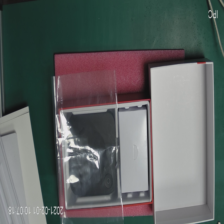

In [8]:
image = tf.keras.preprocessing.image.load_img("./resnet-aoi-2/2-True/training/0_a.png", target_size=IMAGE_SIZE, interpolation=INTERPOLATION)
display(image)

In [ ]:

input_arr = keras.preprocessing.image.img_to_array(image) / 255
model([input_arr])